<a href="https://colab.research.google.com/github/CorpuzKB/PML-Advance-Topics-notebooks/blob/main/HMM_Inference_TensorFlow.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
!pip install tqdm -q

import numpy as np
import tensorflow as tf
import tensorflow_probability as tfp
import matplotlib.pyplot as plt
import seaborn as sns
from tensorflow import keras
from keras.losses import MeanSquaredError
from IPython.display import set_matplotlib_formats
from tqdm import tqdm

tfd = tfp.distributions
sns.set(rc={"figure.dpi":80, 'savefig.dpi':300})
sns.set_context('notebook')
sns.set_style("ticks")
set_matplotlib_formats('retina')

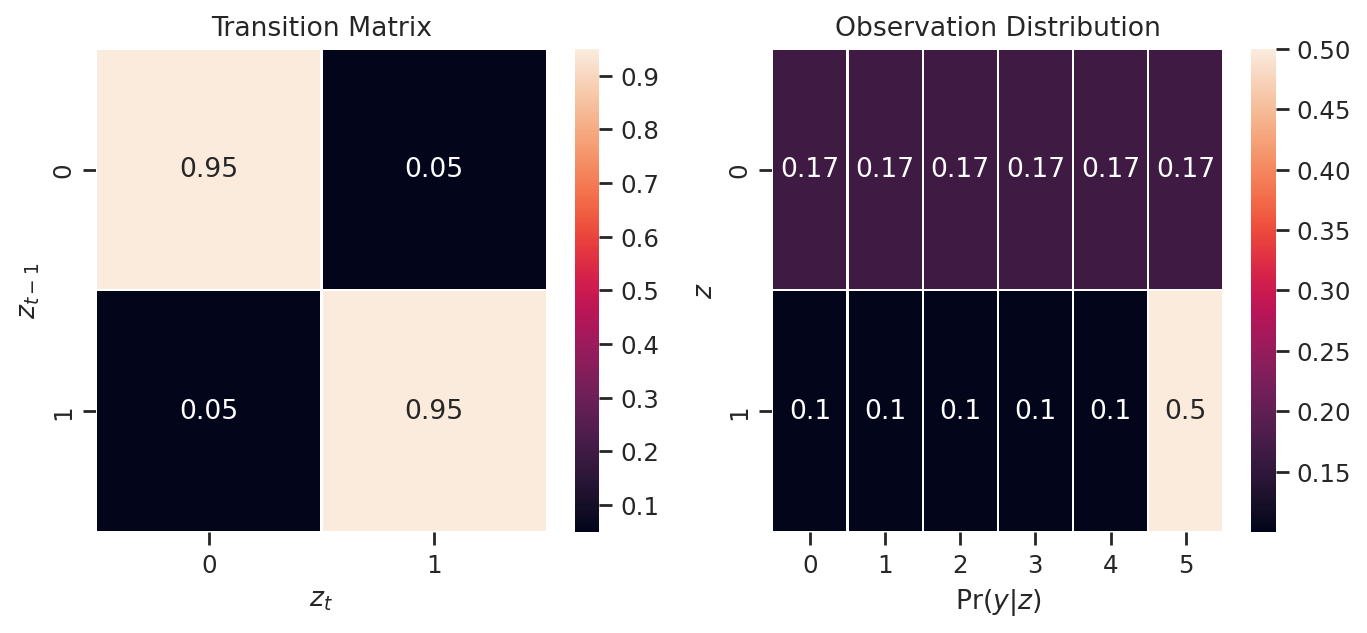

In [436]:
num_states = 2
p_change = 0.05

a_0 = tf.fill([num_states, 1], 1/num_states)
A = tf.fill([num_states, num_states],
            p_change / (num_states - 1))

A = tf.linalg.set_diag(A, tf.fill([num_states], 1 - p_change))
λ = tf.stack([
    tf.squeeze(tf.constant(tf.fill([1, 6], 1/6))),
    tf.constant([*[1/10 for _ in range(5)], 5/10])
    ])

fig, axes = plt.subplots(1, 2, figsize=(10, 4))
sns.heatmap(A, annot=True, linewidth=.5, ax=axes[0])
sns.heatmap(λ, annot=True, linewidth=.5, ax=axes[1])
axes[0].set(xlabel='$z_{t}$', ylabel='$z_{t-1}$', title='Transition Matrix')
axes[1].set(xlabel='$\Pr(y|z)$', ylabel='$z$', title='Observation Distribution')
plt.show()

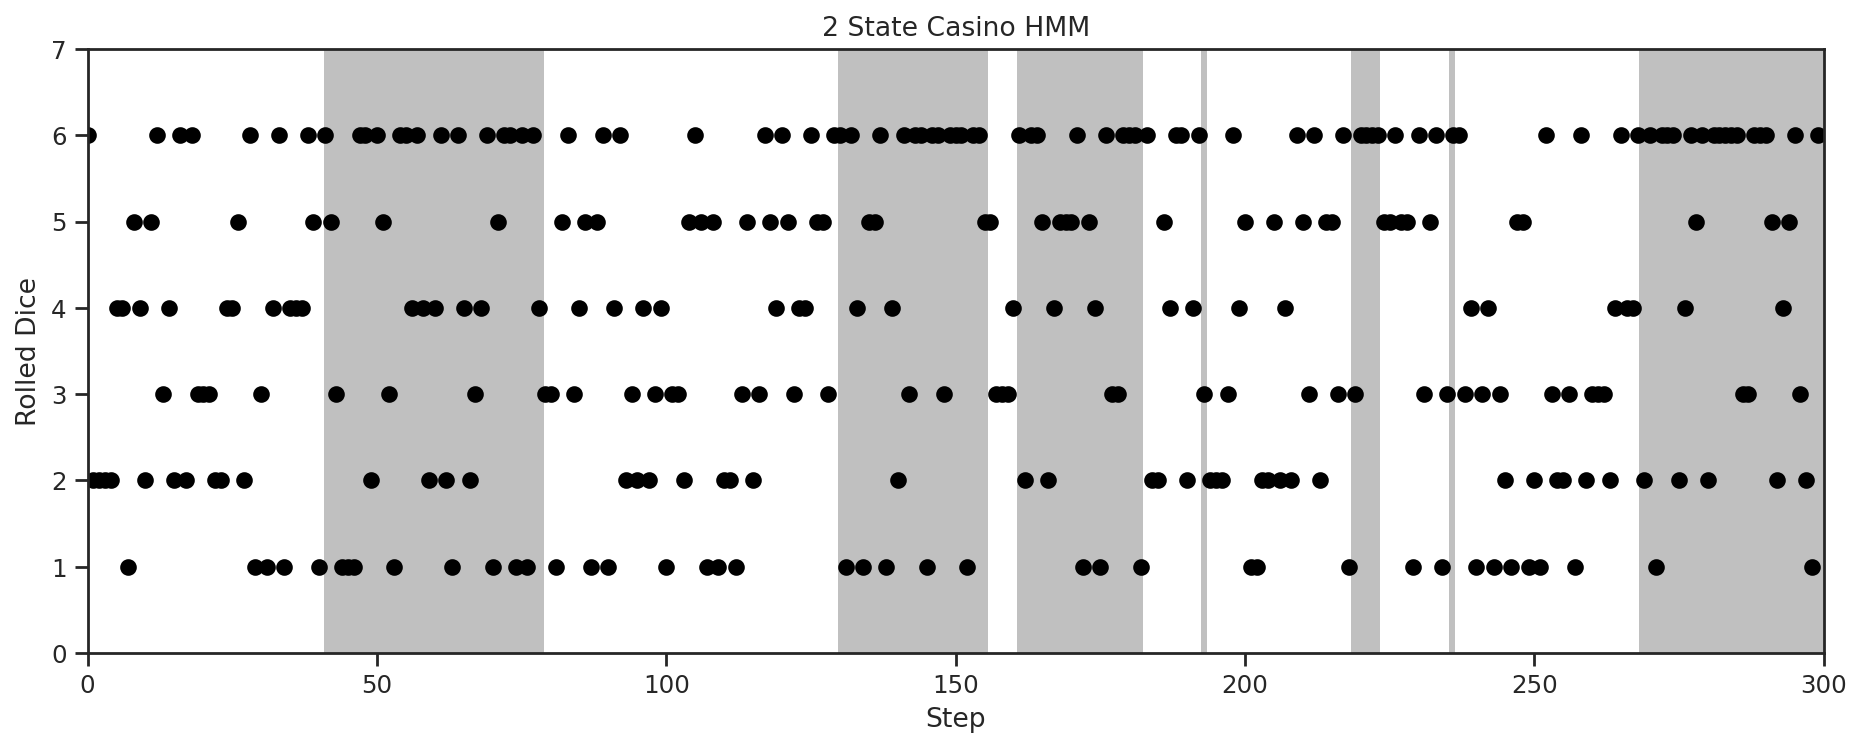

In [437]:
def GenerateCasinoHMM(A, λ, k_0, steps):
  k_t = tfd.Categorical(probs=tf.squeeze(k_0)).sample()
  transition_distribution = tfd.Categorical(probs=A).sample(steps)
  observation_distribution = tfd.Categorical(probs=λ).sample(steps)
  states = [k_t.numpy()]; obs = []
  for i in range(HMM_steps):
    k_t = transition_distribution[i, k_t]
    obs_t = observation_distribution[i, k_t]
    obs.append(obs_t.numpy())
    states.append(k_t.numpy())
  return tf.constant(obs), tf.constant(states)

HMM_steps = 300
y, states_true = GenerateCasinoHMM(A, λ, a_0, HMM_steps)
plt.figure(figsize=(14, 5))
plt.imshow(
    states_true[None, :], extent=(0, HMM_steps, 0, 7), cmap='Greys', alpha=0.25, aspect='auto'
)
plt.scatter(tf.range(HMM_steps), y + 1, s=30, color="black", linewidth=2)
plt.title("{} State Casino HMM".format(num_states)); plt.ylabel('Rolled Dice');  plt.xlabel('Step'); plt.ylim(0,7); plt.show()

In [438]:
def forwards(A, a_t, λ, y):
  a = []
  for i in y:
    a_t = λ[:, i, tf.newaxis] * (tf.transpose(A) @ a_t)
    a_t = a_t/(tf.reduce_sum(a_t))
    a.append(a_t.numpy())
  return tf.constant(a)

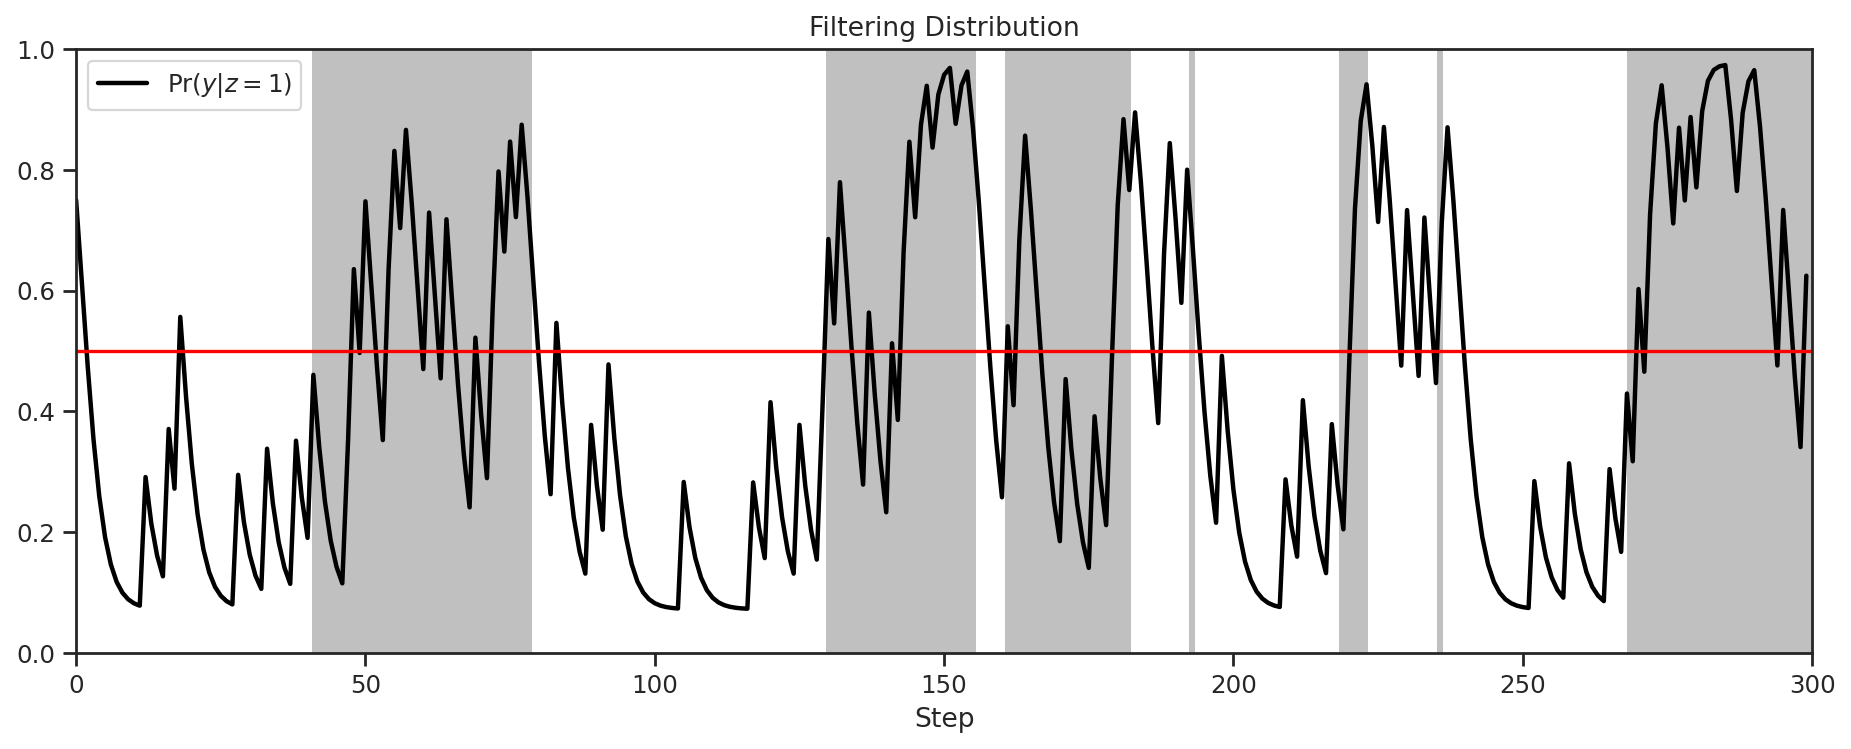

In [439]:
states_p = forwards(A, a_0, λ, y)
states_mode = tf.math.argmax(states_p, axis=-2)

plt.figure(figsize=(14, 5))

plt.imshow(
    states_true[None, :], extent=(0, HMM_steps, 0, 1), cmap='Greys', alpha=0.25, aspect='auto'
)
plt.plot(tf.squeeze(states_p[:,1]), label='$\Pr(y|z=1)$', color="black", linewidth=2)
plt.axhline(0.5, color = 'red')
plt.title("Filtering Distribution"); plt.xlabel('Step'); plt.legend(); plt.show()

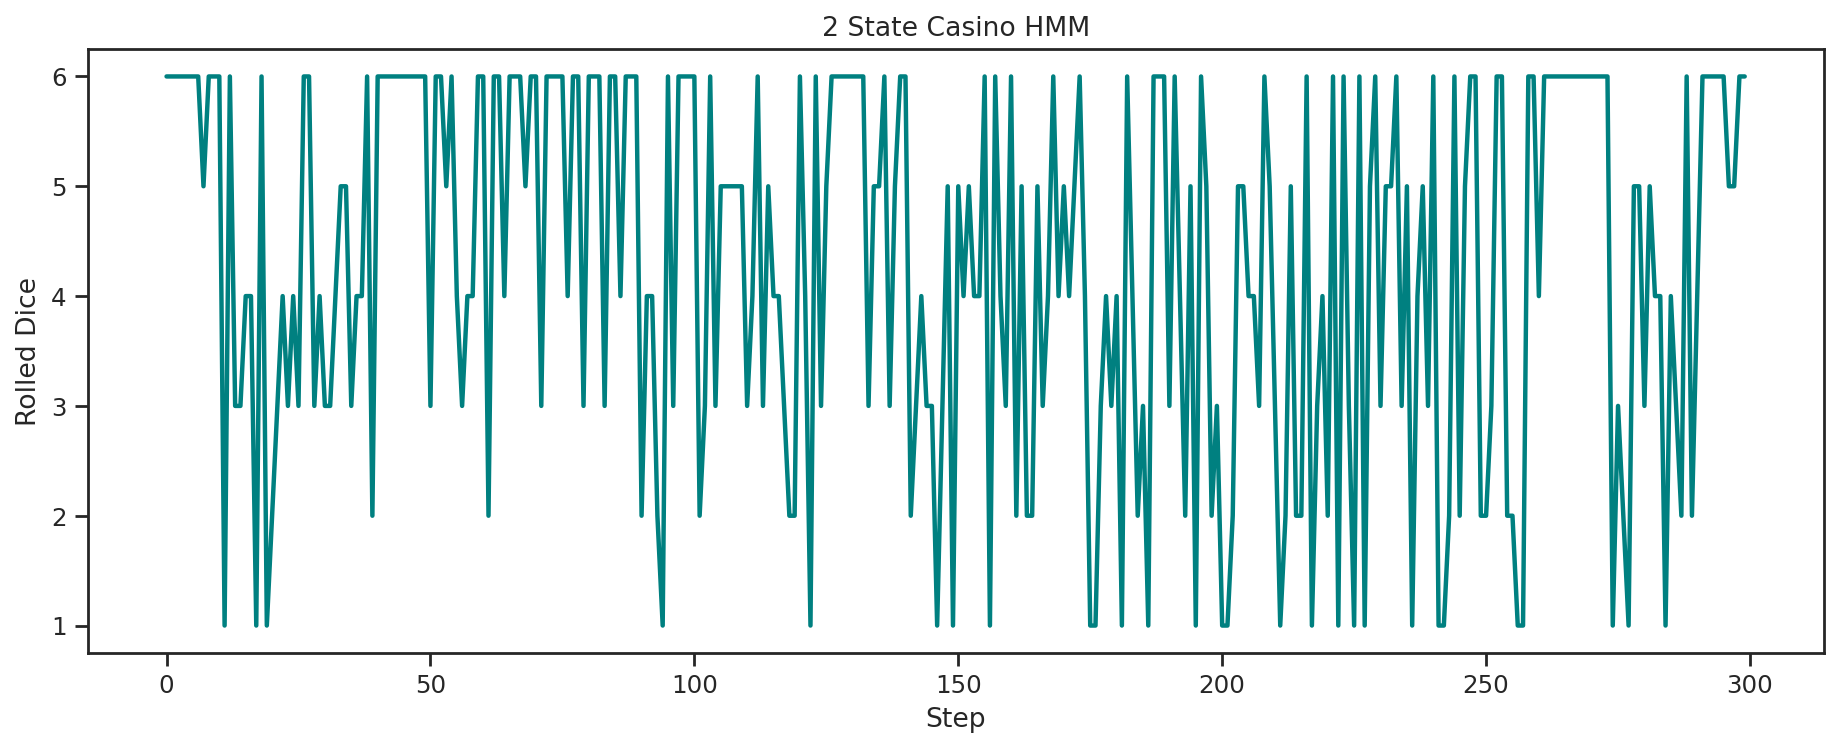

In [342]:
HMM = tfd.HiddenMarkovModel(
    initial_distribution = tfd.Categorical(probs=tf.squeeze(a_0)),
    transition_distribution = tfd.Categorical(probs=A),
    observation_distribution = tfd.Categorical(probs=λ),
    num_steps = HMM_steps)

hmm = tf.constant(HMM.sample())
plt.figure(figsize=(14, 5))
plt.plot(hmm + 1, color="teal", linewidth=2)
plt.title("{} State Casino HMM".format(num_states)); plt.ylabel('Rolled Dice');  plt.xlabel('Step'); plt.show()

In [369]:
m = HMM.posterior_marginals(y)